<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Classifiez automatiquement des biens de consommation
    Projet 6 Notebook image_supervisee_modele_comparaison</h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

<a name="top"></a>

# Sommaire :

**Partie 1**

 - <a href="#C1"> 1.1 Importation des librairies</a>
 - <a href="#C2"> 1.2 Importation et préparation du dataset</a>
 
**Partie 2 : Les differentes approches de préparation des données pour le modèle classification**
 - <a href="#C3"> Les differentes approches de préparation des données pour le modèle classification </a>
 - <a href="#C4"> 2.1 Approche préparation initiale des images </a>
 - <a href="#C5"> 2.2 Approche ImageDatagenerator avec data augmentation </a>
 - <a href="#C6"> 2.3 Approche nouvelle par Dataset sans data augmentation </a>
 - <a href="#C7"> 2.4 Approche nouvelle par dataset avec data augmentation intégrée au modèle VGG16 </a>
 - <a href="#C8"> 2.5 Comparaison des differentes approches </a>
 
**Partie 3 : Comparaison des differents modèles**
 - <a href="#C9"> Comparaison des differents modèles</a>
 - <a href="#C10"> 3.1 Data augmentation intégrée au modèle ResNet50V2 </a>
 - <a href="#C11"> 3.2 Data augmentation intégrée au modèle InceptionResNetV2 </a>
 - <a href="#C12"> 3.3 Data augmentation intégrée au modèle EfficientNetV2B0 </a>
 - <a href="#C13"> 3.4 Comparaison des résultats des modèles </a>
   
**Partie 4 : Optimisation des hyperparamètres du modèle EfficientNetV2B0**
 - <a href="#C14"> Optimisation des hyperparamètres du modèle EfficientNetV2B0</a>
 - <a href="#C15"> 4.1 Optimizer : adam </a>
 - <a href="#C16"> 4.2 Optimizer : rmsprop </a>
 - <a href="#C17"> 4.3 Optimizer : sgd </a>
 - <a href="#C18"> 4.4 Comparaison des résultats </a>
 
**Partie 5 : Conclusion**
 - <a href="#C19"> Conclusion</a> 

# <a name="C1"> 1.1 Importation des librairies</a>
<a href="#top">sommaire</a>

In [1]:
import os
from os import listdir
# Importation des libraries
import sys
import time
import shutil
import numpy as np
import pandas as pd
# import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import missingno as msno

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import manifold, decomposition
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications import InceptionResNetV2
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import warnings
warnings.filterwarnings("ignore")

Num GPUs Available:  1


In [2]:
def seed_everything(seed: int):
    tf.keras.utils.set_random_seed(seed)  # set random seed for keras, numpy, tensorflow, and the 'random' module
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
seed_everything(2)

In [4]:
# Les options pour visualisations des dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
#pd.set_option('display.max_rows', 200)

In [5]:
df_clean = pd.read_csv("df_clean.csv")
df_clean.head(1)

,image,description,category,description_bow,description_bow_lem,description_dl,length_bow,length_dl,label_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multico...",Home Furnishing,key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor...,key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor ...,"key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , elegance polyester multi...",156,248,4


# <a name="C2"> 1.2 Importation et préparation du dataset</a>
<a href="#top">sommaire</a>

# Préparation du dataset

In [6]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/Images/"
list_photos =  df_clean['image'].values.tolist()
print(len(list_photos))

1050


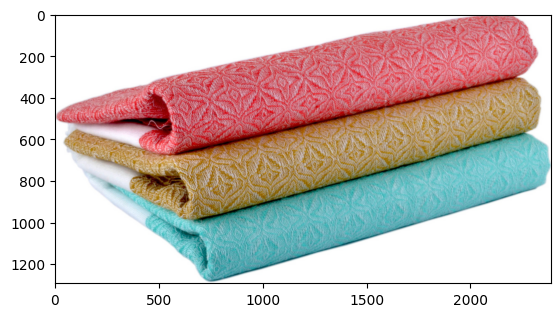

In [7]:
image = imread(path+list_photos[1])
plt.imshow(image)

## Import du dataset

In [8]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/Images/"
#list_photos = [file for file in listdir(path)]
list_photos =  df_clean['image'].values.tolist()
print(len(list_photos))

1050


## Création dataframe pour nos analyses

In [9]:
data = pd.DataFrame()
data["image_path"] = list_photos
data["label_name"] = df_clean["category"]
data["label"] = df_clean["label_category"]
data["image_path_categ"] = data.label_name +"/" + data.image_path
data.head(2)

,image_path,label_name,label,image_path_categ
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,Home Furnishing /55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,Baby Care /7b72c92c2f6c40268628ec5f14c6d590.jpg


In [10]:
data.groupby("label").count()

,image_path,label_name,image_path_categ
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


# Splitter notre data à train, validation et test set

In [11]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/Images/"
path_train = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/train/"
path_test = "/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/test/"

In [12]:
image_dir = path
train_dir = path_train
test_dir = path_test
categories = data.label_name.unique()

df_train, df_test = train_test_split(data, test_size=0.2, stratify=data.label_name, random_state=42)
# Étape 2 : Créer les sous-dossiers pour chaque catégorie dans les dossiers "train" et "test"
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

# Étape 3 : Déplacer les images dans les dossiers de catégorie respectifs
for _, row in df_train.iterrows():
    image_file = row["image_path"]
    image_label = row["label_name"]
    source_file = os.path.join(image_dir, image_file)
    destination_dir = os.path.join(train_dir, image_label)
    shutil.copy(source_file, destination_dir)

for _, row in df_test.iterrows():
    image_file = row["image_path"]
    image_label = row["label_name"]
    source_file = os.path.join(image_dir, image_file)
    destination_dir = os.path.join(test_dir, image_label)
    shutil.copy(source_file, destination_dir)


In [13]:
print(df_train.shape)
print(df_test.shape)

(840, 4)
(210, 4)


In [14]:
df_train.head(2)

,image_path,label_name,label,image_path_categ
799,5188dd28a627807407d93549580afb74.jpg,Home Furnishing,4,Home Furnishing /5188dd28a627807407d93549580afb74.jpg
324,a43fbae655e5d13215b9dd65339fa9d4.jpg,Computers,2,Computers /a43fbae655e5d13215b9dd65339fa9d4.jpg


In [15]:
df_train.image_path_categ = path_train + df_train.image_path_categ
df_train.head(2)

,image_path,label_name,label,image_path_categ
799,5188dd28a627807407d93549580afb74.jpg,Home Furnishing,4,/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/train/Home Furnishing /5188dd28a627807407d93549580afb74.jpg
324,a43fbae655e5d13215b9dd65339fa9d4.jpg,Computers,2,/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/train/Computers /a43fbae655e5d13215b9dd65339fa9d4.jpg


In [16]:
df_test.head(2)

,image_path,label_name,label,image_path_categ
647,3dfd14b667357e26ff6d66761cdc203f.jpg,Baby Care,0,Baby Care /3dfd14b667357e26ff6d66761cdc203f.jpg
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Beauty and Personal Care,1,Beauty and Personal Care /17a73d7c4b02ada2bfeed1115fed08a4.jpg


In [17]:
df_test.image_path_categ = path_test + df_test.image_path_categ
df_test.head(2)

,image_path,label_name,label,image_path_categ
647,3dfd14b667357e26ff6d66761cdc203f.jpg,Baby Care,0,/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/test/Baby Care /3dfd14b667357e26ff6d66761cdc203f.jpg
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Beauty and Personal Care,1,/Users/zeyneperdem/Desktop/ds_prep/p6/data/Flipkart/test/Beauty and Personal Care /17a73d7c4b02ada2bfeed1115fed08a4.jpg


In [18]:
df_train = df_train.reset_index(drop=True)

In [19]:
df_test = df_test.reset_index(drop=True)

In [20]:
df_train.value_counts("label_name")

label_name
Baby Care                        120
Beauty and Personal Care         120
Computers                        120
Home Decor and Festive Needs     120
Home Furnishing                  120
Kitchen and Dining               120
Watches                          120
Name: count, dtype: int64

In [21]:
df_test.value_counts("label_name")

label_name
Baby Care                        30
Beauty and Personal Care         30
Computers                        30
Home Decor and Festive Needs     30
Home Furnishing                  30
Kitchen and Dining               30
Watches                          30
Name: count, dtype: int64

## Création du modèle de classification

In [22]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5, seed=2)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) # rmsprop

    print(model.summary())
    
    return model
    

# <a name="C3"> Les differentes approches de préparation des données pour le modèle classification</a>
<a href="#top">sommaire</a>

## <a name="C4"> 2.1 Approche préparation initiale des images</a>
<a href="#top">sommaire</a>

In [23]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data[col_image_path])) :
        img = (load_img( 
            data[col_image_path][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [24]:
col_image_path = "image_path_categ"
images_np = image_prep_fct(df_train)
print(images_np.shape)

(840, 224, 224, 3)


In [25]:
col_image_path = "image_path_categ"
images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)

(210, 224, 224, 3)


In [26]:
X = images_np
y = to_categorical(df_train['label'])

X_test = images_np_test
y_test = to_categorical(df_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [27]:
y[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [29]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time1 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time1))

Epoch 1/50


2023-08-10 20:52:30.119718: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - ETA: 0s - loss: 8.7211 - accuracy: 0.4349
Epoch 1: val_loss improved from inf to 2.73888, saving model to ./model1_best_weights.h5
20/20 [==============================] - 5s 254ms/step - loss: 8.7211 - accuracy: 0.4349 - val_loss: 2.7389 - val_accuracy: 0.7667
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 4.2893 - accuracy: 0.6952
Epoch 2: val_loss did not improve from 2.73888
20/20 [==============================] - 5s 241ms/step - loss: 4.2893 - accuracy: 0.6952 - val_loss: 2.8412 - val_accuracy: 0.7810
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 3.4940 - accuracy: 0.7286
Epoch 3: val_loss improved from 2.73888 to 2.51923, saving model to ./model1_best_weights.h5
20/20 [==============================] - 5s 247ms/step - loss: 3.4940 - accuracy: 0.7286 - val_loss: 2.5192 - val_accuracy: 0.8000
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 2.6828 - accuracy: 0.7984
Epoch 4: val_

In [31]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 4s 176ms/step - loss: 0.4262 - accuracy: 0.9254
Training Accuracy: 0.9254

7/7 [==============================] - 1s 169ms/step - loss: 2.4556 - accuracy: 0.8381
Validation Accuracy:  0.8381


In [32]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)
# Calculer les précisions et les pertes pour les ensembles d'entraînement, de validation et de test
train_loss1, train_accuracy1 = model1.evaluate(X_train, y_train, verbose=False)
print("Train Accuracy       :  {:.4f}".format(train_accuracy1))
val_loss1, val_accuracy1 = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy1))
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy1))

Train Accuracy       :  0.8778
Validation Accuracy :  0.7905
Test Accuracy       :  0.7905


In [33]:
def res_model_accuracy1(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy, training_time):
   
    # Arrondir les valeurs à 4 décimales
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    val_loss = round(val_loss, 4)
    val_accuracy = round(val_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    training_time = round(training_time, 2)
    
    # Créer une DataFrame avec les résultats arrondis
    results_df = pd.DataFrame({
        'train_loss': [train_loss],
        'val_loss': [val_loss],
        'test_loss': [test_loss],
        'train_accuracy': [train_accuracy],
        'val_accuracy': [val_accuracy],
        'test_accuracy': [test_accuracy],
        'training_time_s': [training_time]
    })
    
    return results_df

In [34]:
res1 = res_model_accuracy1(train_loss1, train_accuracy1, val_loss1, val_accuracy1, test_loss1,
                    test_accuracy1, training_time1)
res1

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,1.0566,2.1413,2.7927,0.8778,0.7905,0.7905,43.78


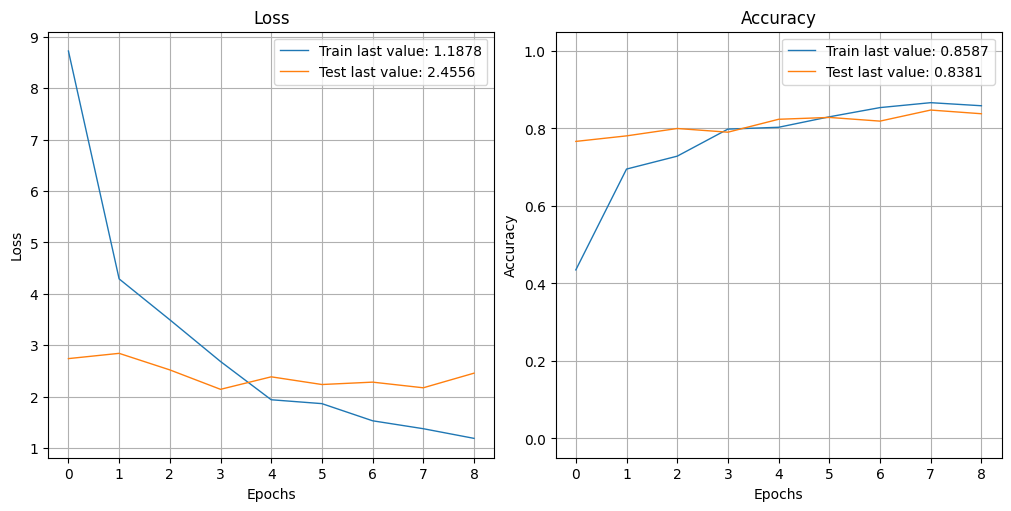

In [35]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [36]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 1s 179ms/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 6 4 2 6 6 3 3 4 1 0 4 1 3 4 2 6 5 2
 5 6 6 0 2 1 5 2 0 1 6 0 6 5 6 3 1 5 5 5 4 3 0 4 0 6 5 4 2 0 3 1 2 5 5 5 2
 4 6 2 4 5 1 4 0 5 4 1 5 1 2 3 3 3 5 4 3 5 0 6 0 2 0 3 0 5 1 5 3 6 1 1 3 3
 0 5 2 5 2 1 6 1 0 5 5 3 4 0 3 0 6 3 6 5 1 2 3 6 1 2 5 2 3 3 3 1 4 0 4 5 0
 5 4 0 6 0 0 4 0 2 3 1 2 4 0 5 5 4 1 5 0 0 1 0 2 1 6 4 2 1 3 4 0 6 2 1 4 6
 5 0 2 3 1 6 0 6 1 5 0 0 0 5 4 1 6 1 2 1 3 6 3 6 5]


In [37]:
from sklearn import cluster, metrics
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[25  1  0  1  3  0  0]
 [ 0 26  2  1  1  0  0]
 [ 3  1 23  0  1  2  0]
 [ 0  1  2 19  1  4  3]
 [ 5  1  0  4 20  0  0]
 [ 1  1  1  0  0 27  0]
 [ 0  2  0  1  0  1 26]]


In [38]:
def conf_mat_transform_2(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [39]:
y_val_pred_transform = conf_mat_transform_2(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[25  1  0  1  3  0  0]
 [ 0 26  2  1  1  0  0]
 [ 3  1 23  0  1  2  0]
 [ 0  1  2 19  1  4  3]
 [ 5  1  0  4 20  0  0]
 [ 1  1  1  0  0 27  0]
 [ 0  2  0  1  0  1 26]]

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        30
           1       0.79      0.87      0.83        30
           2       0.82      0.77      0.79        30
           3       0.73      0.63      0.68        30
           4       0.77      0.67      0.71        30
           5       0.79      0.90      0.84        30
           6       0.90      0.87      0.88        30

    accuracy                           0.79       210
   macro avg       0.79      0.79      0.79       210
weighted avg       0.79      0.79      0.79       210



<Axes: >

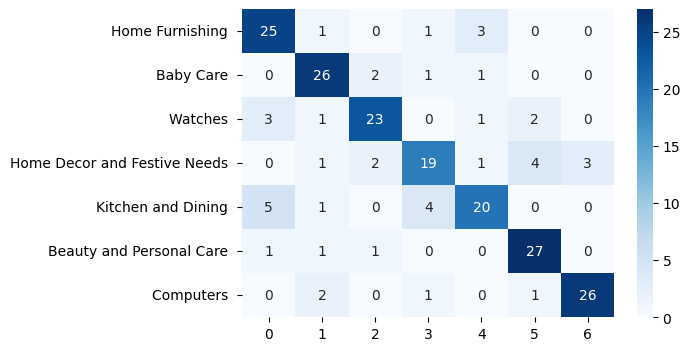

In [40]:
list_labels = data.label_name.unique()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "Home Furnishing" contenant de la neige sont désormais bien affectées à "Home Furnishing" et non pas "Baby Care"

## <a name="C5"> 2.2 Approche ImageDatagenerator avec data augmentation</a>
CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/Imagedf_trainGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

<a href="#top">sommaire</a>

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
# Pour mélanger les images, classées initalement par classe
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [43]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path_categ', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [44]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_train, datagen_train, data_type='training')
val_flow = data_flow_fct(df_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [45]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [47]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time2 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time2))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 8.0589 - accuracy: 0.3619
Epoch 1: val_loss improved from inf to 3.30361, saving model to ./model2_best_weights.h5
20/20 [==============================] - 15s 731ms/step - loss: 8.0589 - accuracy: 0.3619 - val_loss: 3.3036 - val_accuracy: 0.6619
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 3.6195 - accuracy: 0.6556
Epoch 2: val_loss improved from 3.30361 to 2.75584, saving model to ./model2_best_weights.h5
20/20 [==============================] - 14s 699ms/step - loss: 3.6195 - accuracy: 0.6556 - val_loss: 2.7558 - val_accuracy: 0.7333
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 2.8591 - accuracy: 0.7127
Epoch 3: val_loss improved from 2.75584 to 2.36236, saving model to ./model2_best_weights.h5
20/20 [==============================] - 14s 709ms/step - loss: 2.8591 - accuracy: 0.7127 - val_loss: 2.3624 - val_accuracy: 0.7619
Epoch 4/50
20/20 [=============================

In [48]:
# Score du dernier epoch
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 10s 507ms/step - loss: 0.2628 - accuracy: 0.9524
Training Accuracy   : 0.9524

7/7 [==============================] - 3s 416ms/step - loss: 2.4761 - accuracy: 0.7857
Validation Accuracy :  0.7857


In [49]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)
# Calculer les précisions et les pertes pour les ensembles d'entraînement, de validation et de test
train_loss2, train_accuracy2 = model2.evaluate(train_flow, verbose=False)
print("Train Accuracy       :  {:.4f}".format(train_accuracy2))
val_loss2, val_accuracy2 = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy2))
test_loss2, test_accuracy2 = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy2))

Train Accuracy       :  0.9571
Validation Accuracy :  0.7905
Test Accuracy       :  0.7905


In [50]:
res2 = res_model_accuracy1(train_loss2, train_accuracy2, val_loss2, val_accuracy2, test_loss2,
                    test_accuracy2, training_time2)
res2

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.2587,2.1708,3.0972,0.9571,0.7905,0.7905,253.87


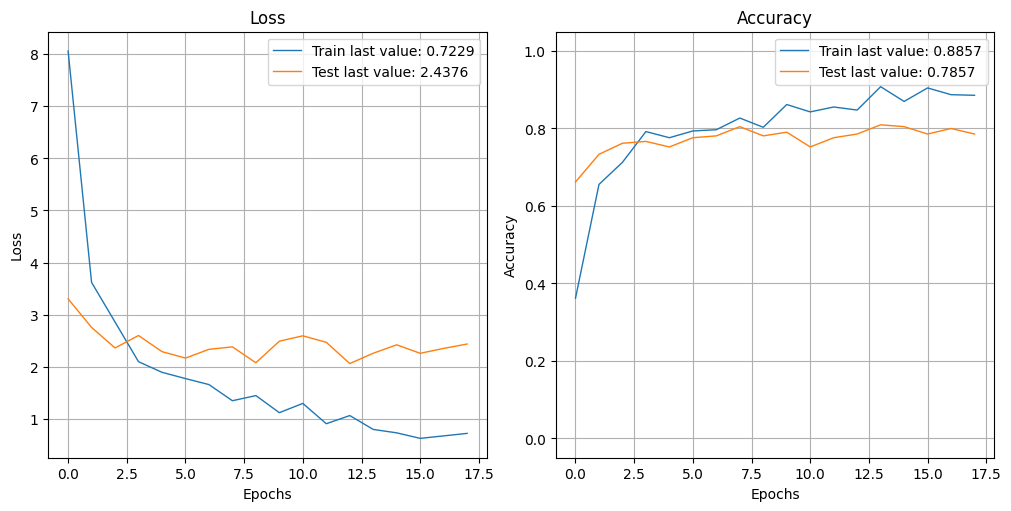

In [51]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## <a name="C6"> 2.3 Approche nouvelle par Dataset sans data augmentation</a>
CF https://www.tensorflow.org/tutorials/load_df_train/images

<a href="#top">sommaire</a>

In [52]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [53]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [54]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [56]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time3 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time3))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 13.6368 - accuracy: 0.3603
Epoch 1: val_loss improved from inf to 3.38486, saving model to ./model3_best_weights.h5
20/20 [==============================] - 7s 290ms/step - loss: 13.6368 - accuracy: 0.3603 - val_loss: 3.3849 - val_accuracy: 0.7381
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 6.1294 - accuracy: 0.6540
Epoch 2: val_loss improved from 3.38486 to 3.14717, saving model to ./model3_best_weights.h5
20/20 [==============================] - 6s 287ms/step - loss: 6.1294 - accuracy: 0.6540 - val_loss: 3.1472 - val_accuracy: 0.7857
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 4.1099 - accuracy: 0.7349
Epoch 3: val_loss improved from 3.14717 to 2.92080, saving model to ./model3_best_weights.h5
20/20 [==============================] - 6s 282ms/step - loss: 4.1099 - accuracy: 0.7349 - val_loss: 2.9208 - val_accuracy: 0.7857
Epoch 4/50
20/20 [==============================

In [57]:
# Score du dernier epoch
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 4s 184ms/step - loss: 0.7402 - accuracy: 0.9016
Training Accuracy   : 0.9016

7/7 [==============================] - 2s 173ms/step - loss: 2.9489 - accuracy: 0.7667
Validation Accuracy :  0.7667


In [58]:
# Score de l'epoch optimal
model3.load_weights(model3_save_path)
# Calculer les précisions et les pertes pour les ensembles d'entraînement, de validation et de test
train_loss3, train_accuracy3 = model3.evaluate(dataset_train, verbose=False)
print("Train Accuracy       :  {:.4f}".format(train_accuracy3))
val_loss3, val_accuracy3 = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy3))
test_loss3, test_accuracy3 = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy3))

Train Accuracy       :  0.9016
Validation Accuracy :  0.7952
Test Accuracy       :  0.7857


In [59]:
res3 = res_model_accuracy1(train_loss3, train_accuracy3, val_loss3, val_accuracy3, test_loss3,
                    test_accuracy3, training_time3)
res3

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,1.2018,2.5776,3.0441,0.9016,0.7952,0.7857,62.97


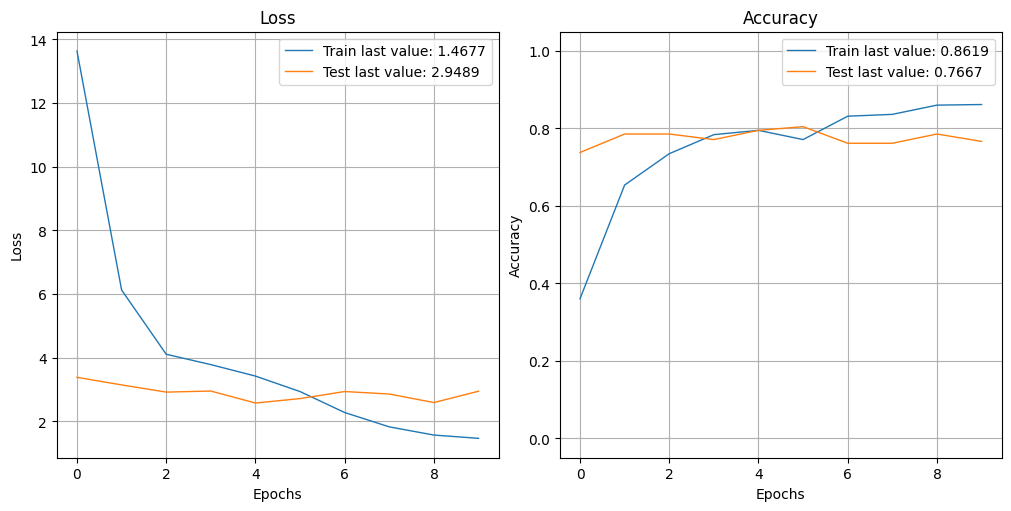

In [60]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## <a name="C7"> 2.4 Approche nouvelle par dataset avec data augmentation intégrée au modèle VGG16</a>
CF https://www.tensorflow.org/tutorials/images/data_augmentation

<a href="#top">sommaire</a>

In [61]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [62]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [63]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [64]:
def create_model_fct2(model, optimizer) :
    # data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3), seed=2),
        RandomRotation(0.1, seed=2),
        RandomZoom(0.1, seed=2),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5, seed=2),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())
    
    return model  

In [65]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2(VGG16, 'adam')

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [67]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time4 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time4))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9695 - accuracy: 0.2159
Epoch 1: val_loss improved from inf to 1.39778, saving model to ./model4_best_weights.h5
20/20 [==============================] - 7s 319ms/step - loss: 1.9695 - accuracy: 0.2159 - val_loss: 1.3978 - val_accuracy: 0.5714
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4109 - accuracy: 0.5000
Epoch 2: val_loss improved from 1.39778 to 1.10038, saving model to ./model4_best_weights.h5
20/20 [==============================] - 7s 310ms/step - loss: 1.4109 - accuracy: 0.5000 - val_loss: 1.1004 - val_accuracy: 0.6571
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1699 - accuracy: 0.6063
Epoch 3: val_loss improved from 1.10038 to 0.91004, saving model to ./model4_best_weights.h5
20/20 [==============================] - 7s 309ms/step - loss: 1.1699 - accuracy: 0.6063 - val_loss: 0.9100 - val_accuracy: 0.7143
Epoch 4/50
20/20 [==============================] 

In [68]:
# Score du dernier epoch
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 4s 185ms/step - loss: 0.2797 - accuracy: 0.9190
Training Accuracy   : 0.9190

7/7 [==============================] - 2s 171ms/step - loss: 0.5479 - accuracy: 0.8143
Validation Accuracy :  0.8143


In [69]:
def res_model_accuracy2(model, model_save_path, training_time):
    # Charger les meilleurs poids du modèle sauvegardés lors de l'entraînement
    model.load_weights(model_save_path)
    
    # Calculer les précisions et les pertes pour les ensembles d'entraînement, de validation et de test
    train_loss, train_accuracy = model.evaluate(dataset_train, verbose=False)
    val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
    
    # Arrondir les valeurs à 4 décimales
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    val_loss = round(val_loss, 4)
    val_accuracy = round(val_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    training_time = round(training_time, 2)
    
    # Créer une DataFrame avec les résultats arrondis
    results_df = pd.DataFrame({
        'train_loss': [train_loss],
        'val_loss': [val_loss],
        'test_loss': [test_loss],
        'train_accuracy': [train_accuracy],
        'val_accuracy': [val_accuracy],
        'test_accuracy': [test_accuracy],
        'training_time_s': [training_time]
    })
    
    return results_df

In [70]:
res4 = res_model_accuracy2(model4, model4_save_path, training_time4)
res4

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.3021,0.5137,0.7543,0.9143,0.8381,0.7714,224.93


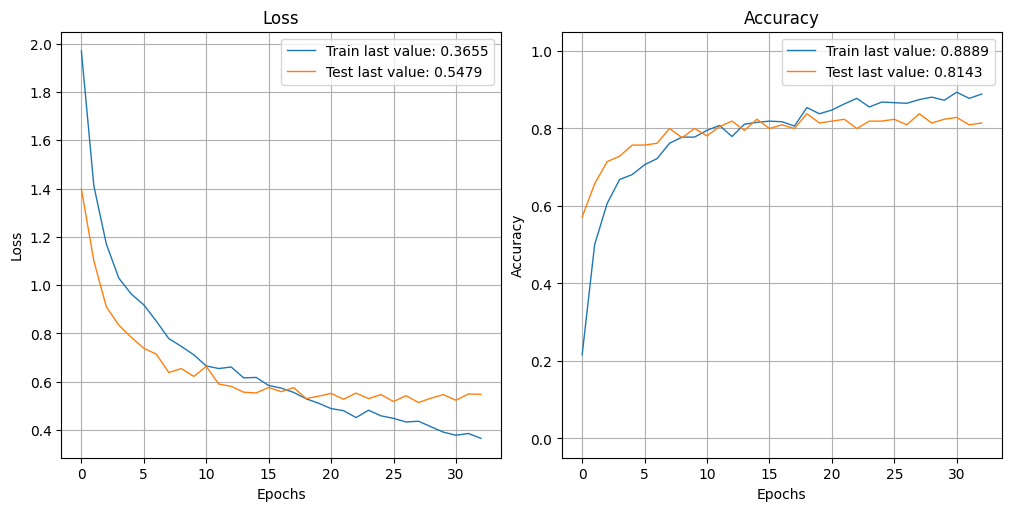

In [71]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

Data augmentation :
* rotation
* décalage de largeur et hauteur 
* retournement horizontal 
* zoom


* Data augmentation évite l’overfitting

* Les courbes de train et validation sets suivent les mêmes tendances


## <a name="C8"> 2.5 Comparaison des differentes approches</a>

<a href="#top">sommaire</a>

In [72]:
res_approches = pd.concat([res1, res2, res3, res4])
res_approches.index = ["Prép initiale img", "ImageDatagenerator data augmentation",
                       "Dataset sans data augmentation",
                       "Data augmentation intégrée au modèle"]
res_approches

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
Prép initiale img,1.0566,2.1413,2.7927,0.8778,0.7905,0.7905,43.78
ImageDatagenerator data augmentation,0.2587,2.1708,3.0972,0.9571,0.7905,0.7905,253.87
Dataset sans data augmentation,1.2018,2.5776,3.0441,0.9016,0.7952,0.7857,62.97
Data augmentation intégrée au modèle,0.3021,0.5137,0.7543,0.9143,0.8381,0.7714,224.93


On obtient de meilleurs résultats avec la data augmentation intégrée au modèle

# <a name="C9"> Comparaison des differents modèles </a>

<a href="#top">sommaire</a>

## <a name="C10"> 3.1 Data augmentation intégrée au modèle ResNet50V2 </a>
<a href="#top">sommaire</a>

In [73]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = create_model_fct2(ResNet50V2, "adam")

# Création du callback
model5_save_path = "./model5_best_weights.h5"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [74]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time5 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time5))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.1709 - accuracy: 0.5397
Epoch 1: val_loss improved from inf to 0.83761, saving model to ./model5_best_weights.h5
20/20 [==============================] - 7s 277ms/step - loss: 2.1709 - accuracy: 0.5397 - val_loss: 0.8376 - val_accuracy: 0.7857
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.0737 - accuracy: 0.7746
Epoch 2: val_loss improved from 0.83761 to 0.76561, saving model to ./model5_best_weights.h5
20/20 [==============================] - 5s 216ms/step - loss: 1.0737 - accuracy: 0.7746 - val_loss: 0.7656 - val_accuracy: 0.8524
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.8366 - accuracy: 0.8016
Epoch 3: val_loss improved from 0.76561 to 0.70287, saving model to ./model5_best_weights.h5
20/20 [==============================] - 5s 210ms/step - loss: 0.8366 - accuracy: 0.8016 - val_loss: 0.7029 - val_accuracy: 0.8381
Epoch 4/50
20/20 [==============================] 

In [75]:
res5 = res_model_accuracy2(model5, model5_save_path, training_time5)
res5

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.1672,0.5821,0.8822,0.9556,0.8524,0.8238,59.56


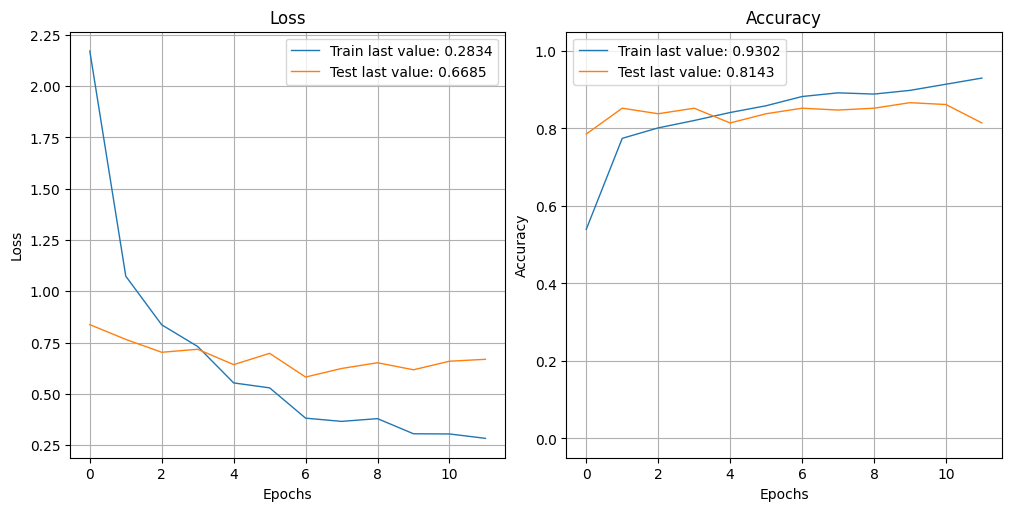

In [76]:
show_history(history5)
plot_history(history5, path="standard.png")
plt.close()

## <a name="C11"> 3.2 Data augmentation intégrée au modèle InceptionResNetV2 </a>
<a href="#top">sommaire</a>

In [77]:
# Création du modèle
with tf.device('/gpu:0'): 
    model6 = create_model_fct2(InceptionResNetV2, "adam")

# Création du callback
model6_save_path = "./model6_best_weights.h5"
checkpoint = ModelCheckpoint(model6_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [78]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history6 = model6.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time6 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time6))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 3.0250 - accuracy: 0.4143
Epoch 1: val_loss improved from inf to 0.96699, saving model to ./model6_best_weights.h5
20/20 [==============================] - 22s 843ms/step - loss: 3.0250 - accuracy: 0.4143 - val_loss: 0.9670 - val_accuracy: 0.7667
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.7786 - accuracy: 0.6905
Epoch 2: val_loss improved from 0.96699 to 0.74205, saving model to ./model6_best_weights.h5
20/20 [==============================] - 8s 374ms/step - loss: 1.7786 - accuracy: 0.6905 - val_loss: 0.7421 - val_accuracy: 0.8190
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.7349
Epoch 3: val_loss improved from 0.74205 to 0.71707, saving model to ./model6_best_weights.h5
20/20 [==============================] - 8s 355ms/step - loss: 1.3938 - accuracy: 0.7349 - val_loss: 0.7171 - val_accuracy: 0.8286
Epoch 4/50
20/20 [==============================]

In [79]:
res6 = res_model_accuracy2(model6, model6_save_path, training_time6)
res6

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.5552,0.7171,0.8658,0.8651,0.8286,0.8,72.23


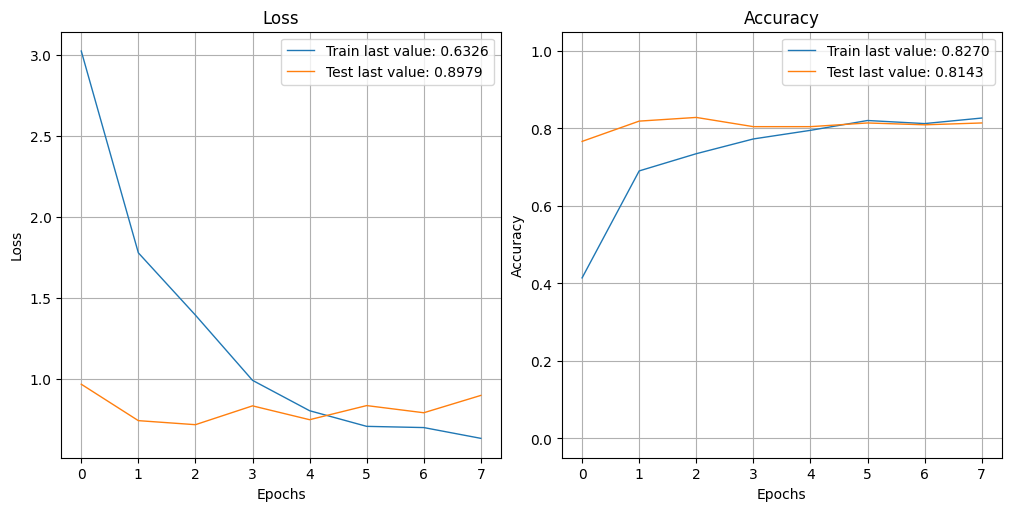

In [80]:
show_history(history6)
plot_history(history6, path="standard.png")
plt.close()

## <a name="C12"> 3.3 Data augmentation intégrée au modèle EfficientNetV2B0 </a>
<a href="#top">sommaire</a>

In [81]:
def create_model_fct3(model, optimizer) :
    # data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3), seed=2),
        RandomRotation(0.1, seed=2),
        RandomZoom(0.1, seed=2),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                #Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5, seed=2),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())
    
    return model  

## <a name="C15"> Optimizer : adam </a>
<a href="#top">sommaire</a>

In [82]:
# Création du modèle
with tf.device('/gpu:0'): 
    model7 = create_model_fct3(EfficientNetV2B0, "adam")

# Création du callback
model7_save_path = "./model7_best_weights.h5"
checkpoint = ModelCheckpoint(model7_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                

In [83]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history7 = model7.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time7 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time7))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.6175
Epoch 1: val_loss improved from inf to 0.52291, saving model to ./model7_best_weights.h5
20/20 [==============================] - 15s 523ms/step - loss: 1.1657 - accuracy: 0.6175 - val_loss: 0.5229 - val_accuracy: 0.8429
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.8206
Epoch 2: val_loss improved from 0.52291 to 0.46399, saving model to ./model7_best_weights.h5
20/20 [==============================] - 5s 240ms/step - loss: 0.5925 - accuracy: 0.8206 - val_loss: 0.4640 - val_accuracy: 0.8619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8540
Epoch 3: val_loss improved from 0.46399 to 0.45200, saving model to ./model7_best_weights.h5
20/20 [==============================] - 5s 216ms/step - loss: 0.4708 - accuracy: 0.8540 - val_loss: 0.4520 - val_accuracy: 0.8667
Epoch 4/50
20/20 [==============================]

In [84]:
res7 = res_model_accuracy2(model7, model7_save_path, training_time7)
res7

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.11,0.4279,0.5058,0.9603,0.8952,0.8476,70.76


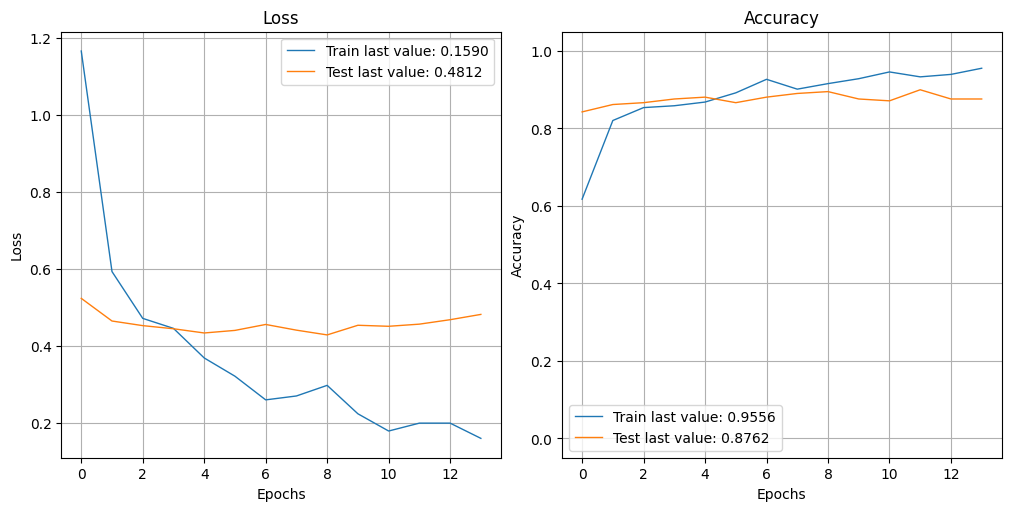

In [85]:
show_history(history7)
plot_history(history7, path="standard.png")
plt.close()

## <a name="C13"> 3.4 Comparaison des résultats des modèles </a>
<a href="#top">sommaire</a>

### Comparaison des résultats des modèles VGG16, ResNet50, InceptionResNetV2, EfficientNetV2B0

In [86]:
res_models = pd.concat([res4, res5, res6, res7])
res_models.index = ["VGG16", "ResNet50V2", "InceptionResNetV2", "EfficientNetV2B0"]
res_models

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
VGG16,0.3021,0.5137,0.7543,0.9143,0.8381,0.7714,224.93
ResNet50V2,0.1672,0.5821,0.8822,0.9556,0.8524,0.8238,59.56
InceptionResNetV2,0.5552,0.7171,0.8658,0.8651,0.8286,0.8000,72.23
EfficientNetV2B0,0.1100,0.4279,0.5058,0.9603,0.8952,0.8476,70.76


On obtient de meilleurs résultats avec EfficientNetV2B0

# <a name="C14"> Optimisation des hyperparamètres du modèle EfficientNetV2B0 </a>
<a href="#top">sommaire</a>

Optimizer ajuste les poids du modèle pendant l'entraînement afin de minimiser la fonction de perte.

* SGD (Stochastic Gradient Descent) : Il utilise le gradient de la fonction de perte par rapport à chaque poids. Il peut être efficace, mais sa convergence peut être lente et sensible aux hyperparamètres.

* RMSProp : Il utilise une moyenne pondérée des carrés des gradients précédents pour ajuster les poids. 

* Adam (Adaptive Moment Estimation) : Il ajuste le taux d'apprentissage pour chaque poids individuel en fonction de la moyenne des gradients précédents. Cela peut aider à accélérer la convergence.


### Optimisation des hyperparamètres Optimizer du modèle EfficientNetV2B0 avec data augmentation intégrée au modèle 

In [87]:
def create_model_fct3(model, optimizer) :
    # data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3), seed=2),
        RandomRotation(0.1, seed=2),
        RandomZoom(0.1, seed=2),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                #Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5, seed=2),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())
    
    return model  

## <a name="C16"> 4.2 Optimizer : rmsprop </a>
<a href="#top">sommaire</a>

In [88]:
# Création du modèle
with tf.device('/gpu:0'): 
    model8 = create_model_fct3(EfficientNetV2B0, "rmsprop")

# Création du callback
model8_save_path = "./model8_best_weights.h5"
checkpoint = ModelCheckpoint(model8_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                

In [89]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history8 = model8.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time8 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time8))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.6429
Epoch 1: val_loss improved from inf to 0.52918, saving model to ./model8_best_weights.h5
20/20 [==============================] - 16s 589ms/step - loss: 1.0872 - accuracy: 0.6429 - val_loss: 0.5292 - val_accuracy: 0.8476
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.8095
Epoch 2: val_loss improved from 0.52918 to 0.49926, saving model to ./model8_best_weights.h5
20/20 [==============================] - 5s 201ms/step - loss: 0.6374 - accuracy: 0.8095 - val_loss: 0.4993 - val_accuracy: 0.8429
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8381
Epoch 3: val_loss did not improve from 0.49926
20/20 [==============================] - 5s 228ms/step - loss: 0.5224 - accuracy: 0.8381 - val_loss: 0.5070 - val_accuracy: 0.8667
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8317
E

In [90]:
res_rmsprop = res_model_accuracy2(model8, model8_save_path, training_time8)
res_rmsprop

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.1059,0.4702,0.5316,0.9635,0.8476,0.8429,72.72


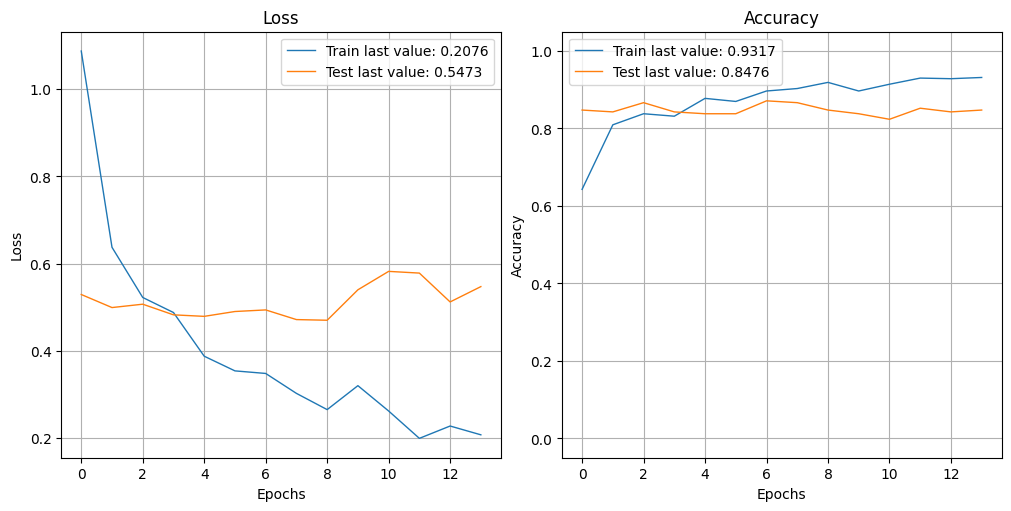

In [91]:
show_history(history8)
plot_history(history8, path="standard.png")
plt.close()

## <a name="C17"> 4.3 Optimizer : sgd </a>
<a href="#top">sommaire</a>

In [92]:
# Création du modèle
with tf.device('/gpu:0'): 
    model9 = create_model_fct3(EfficientNetV2B0, "sgd")

# Création du callback
model9_save_path = "./model9_best_weights.h5"
checkpoint = ModelCheckpoint(model9_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 256)               327936    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 7)               

In [93]:
# Enregistrer le moment où l'entraînement commence
start_time = time.time()
# Entraîner le modèle avec les données d'entraînement
with tf.device('/gpu:0'): 
    history9 = model9.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
# Enregistrer le moment où l'entraînement se termine
end_time = time.time()
# Calculer le temps d'entraînement
training_time9 = end_time - start_time
# Afficher le temps d'entraînement
print("Training Time: {:.2f} seconds".format(training_time9))

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0698 - accuracy: 0.2159
Epoch 1: val_loss improved from inf to 1.62963, saving model to ./model9_best_weights.h5
20/20 [==============================] - 19s 702ms/step - loss: 2.0698 - accuracy: 0.2159 - val_loss: 1.6296 - val_accuracy: 0.4143
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.6067 - accuracy: 0.4190
Epoch 2: val_loss improved from 1.62963 to 1.27592, saving model to ./model9_best_weights.h5
20/20 [==============================] - 6s 270ms/step - loss: 1.6067 - accuracy: 0.4190 - val_loss: 1.2759 - val_accuracy: 0.6286
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2911 - accuracy: 0.5825
Epoch 3: val_loss improved from 1.27592 to 1.05573, saving model to ./model9_best_weights.h5
20/20 [==============================] - 5s 208ms/step - loss: 1.2911 - accuracy: 0.5825 - val_loss: 1.0557 - val_accuracy: 0.7286
Epoch 4/50
20/20 [==============================]

Epoch 27/50
20/20 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.8651
Epoch 27: val_loss improved from 0.48377 to 0.47937, saving model to ./model9_best_weights.h5
20/20 [==============================] - 4s 172ms/step - loss: 0.4700 - accuracy: 0.8651 - val_loss: 0.4794 - val_accuracy: 0.8381
Epoch 28/50
20/20 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.8492
Epoch 28: val_loss improved from 0.47937 to 0.47699, saving model to ./model9_best_weights.h5
20/20 [==============================] - 4s 167ms/step - loss: 0.4654 - accuracy: 0.8492 - val_loss: 0.4770 - val_accuracy: 0.8429
Epoch 29/50
20/20 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8508
Epoch 29: val_loss improved from 0.47699 to 0.47256, saving model to ./model9_best_weights.h5
20/20 [==============================] - 4s 175ms/step - loss: 0.4696 - accuracy: 0.8508 - val_loss: 0.4726 - val_accuracy: 0.8429
Epoch 30/50
20/20 [=====================

In [94]:
res_sgd = res_model_accuracy2(model9, model9_save_path, training_time9)
res_sgd

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
0,0.2466,0.4468,0.4998,0.9206,0.8619,0.8571,284.33


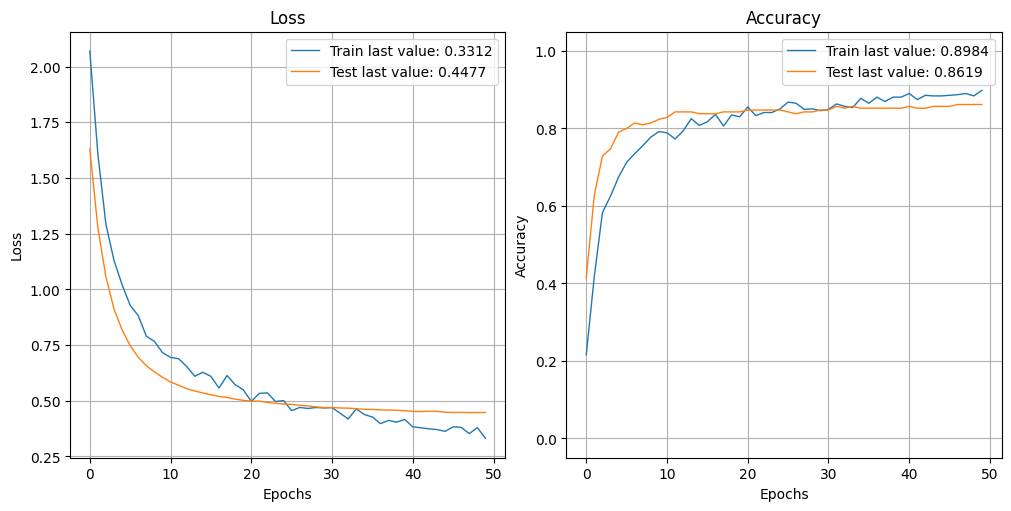

In [95]:
show_history(history9)
plot_history(history9, path="standard.png")
plt.close()

## <a name="C18"> 4.4 Comparaison des résultats des optimizers le modèle EfficientNetV2B0</a>
<a href="#top">sommaire</a>

In [96]:
res_optimizers = pd.concat([res7, res_rmsprop, res_sgd])
res_optimizers.index = ["adam", "rmsprop", "sgd"]
res_optimizers.sort_values("test_accuracy", ascending=False)

,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,training_time_s
sgd,0.2466,0.4468,0.4998,0.9206,0.8619,0.8571,284.33
adam,0.1100,0.4279,0.5058,0.9603,0.8952,0.8476,70.76
rmsprop,0.1059,0.4702,0.5316,0.9635,0.8476,0.8429,72.72


On obtient de meilleurs résultats avec "sgd", mais en raison du temps d'entraînement, on privilégie "adam".

# <a name="C19">Conclusion</a>
<a href="#top">sommaire</a>

* On a utilisé le description et l’image des produits pour nos analyses .
* On a effectué les études de faisabilité pour les deux variables.
* Selon les résultats des clustering, on a constaté qu’on peut faire une classification.
* D’après les résultats de classification, on a obtenu les meilleurs résultats avec le modèle CNN EfficientNetV2B0
* On a essayé d'améliorer la performance du modèle avec hyperparamètres tuning.
* Les résultats de la classification pour le text et l’image sont satisfaisants.
* Une extraction des 10 premiers produits de champagne a été obtenu via l’API.
* Dans toutes phases de la collecte et du stockage des données, on a respecté des normes RGPD.
 
* On peut essayer de faire une classification avec les features de description et l’image du produit ensemble.
* On peut collecter des données supplémentaires.
